In [1]:
### Set CUDA device
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '6'

In [2]:
import numpy as np
import torch
from torch import Tensor, nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import sys
from omegaconf import OmegaConf
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict
from torchvision.transforms import GaussianBlur
from torchmetrics.functional.classification import dice
from sklearn.covariance import LedoitWolf

## Augmentations
from batchgenerators.transforms.noise_transforms import augment_gaussian_blur


sys.path.append('../')
from data_utils import get_eval_data
from model.unet import get_unet
from utils import  epoch_average, UMapGenerator
from model.mahalanobis_adatper import (
    get_pooling_mahalanobis_detector, 
    get_batchnorm_mahalanobis_detector
)
from model.wrapper import PoolingMahalanobisWrapper, BatchNormMahalanobisWrapper

# from losses import (
#     DiceScoreCalgary, 
#     DiceScoreMMS
# )

nnUNet_raw_data_base is not defined and nnU-Net can only be used on data for which preprocessed files are already present on your system. nnU-Net cannot be used for experiment planning and preprocessing like this. If this is not intended, please read documentation/setting_up_paths.md for information on how to set this up properly.
RESULTS_FOLDER is not defined and nnU-Net cannot be used for training or inference. If this is not intended behavior, please read documentation/setting_up_paths.md for information on how to set this up.


In [3]:
### Load basic config
cfg = OmegaConf.load('../configs/basic_config_venusberg.yaml')
OmegaConf.update(cfg, 'run.iteration', 0)

In [4]:
### Set dataset, either brain or heart
DATA_KEY = 'heart'
OmegaConf.update(cfg, 'run.data_key', DATA_KEY)


### get model
# available models:
#     - default-8
#     - default-16
#     - monai-8-4-4
#     - monai-16-4-4
#     - monai-16-4-8
#     - monai-32-4-4
#     - monai-64-4-4
#     - swinunetr


unet_name = 'default-8'
postfix = '_no-blurring'
args = unet_name.split('-')
cfg.unet[DATA_KEY].pre = unet_name + postfix
cfg.unet[DATA_KEY].arch = args[0]
cfg.unet[DATA_KEY].n_filters_init = int(args[1])

if args[0] == 'monai':
    cfg.unet[DATA_KEY].depth = int(args[2])
    cfg.unet[DATA_KEY].num_res_units = int(args[3])


unet, state_dict = get_unet(
    cfg,
    update_cfg_with_swivels=False,
    return_state_dict=True)
unet.load_state_dict(state_dict)
_ = unet.cuda()

In [5]:
# Set debug mode for only a small fraction of the datasets. Speeds up this cell by alot
cfg.debug = False

# update config with default values
OmegaConf.update(
    cfg, 
    'eval',
    OmegaConf.load('../configs/eval/unet_config.yaml')
)

# Wether and how you want to subset in case of Brain data. WARNING:
# After subsetting the eval below will not work with surface
# Dice anymore, because volumes are fragmented. 
APPLY_SUBSETTING = True
OmegaConf.update(cfg, 'eval.data.subset.apply', APPLY_SUBSETTING)
subset_params = {
    'n_cases': 256,  # selects at most so many cases
    'fraction': 0.1, # selects from the 10% worst cases w.r.t to a model
}
OmegaConf.update(
    cfg, 
    'eval.data.subset.params', 
    OmegaConf.create(subset_params)
)

if cfg.eval.data.subset.apply:
    subset_dict = OmegaConf.to_container(
        cfg.eval.data.subset.params, 
        resolve=True, 
        throw_on_missing=True
    )
    subset_dict['unet'] = unet
else:
    subset_dict = None

### select the datasets within the domain
# get training data
cfg.eval.data.training = True
# get validation data
cfg.eval.data.validation = False
# get testing data
# Options for Brain are any subset of [1, 2, 3, 4, 5] or 'all' 
# Options for Heart are any subset of ['A', 'B', 'C', 'D'] or 'all'
cfg.eval.data.testing = [] #'all'


data = get_eval_data(
    train_set=cfg.eval.data.training,
    val_set=cfg.eval.data.validation,
    test_sets=cfg.eval.data.testing,    
    cfg=cfg,
    subset_dict=subset_dict
)

print(f'\nAvailable datasets are: {list(data.keys())}')

loading dataset
loading all case properties



Available datasets are: ['train']


In [6]:
dataloader = DataLoader(data['train'], 
    batch_size=32, 
    shuffle=False, 
    drop_last=False
)

In [7]:
@torch.no_grad()
def eval_heart_set(
    model: nn.Module, 
    dataloader: DataLoader, 
) -> Dict:
    model.eval()
    
    # Gaussian Params (from gaussian_filter, scipy)
    blurs = []
    truncate=4.0

    DSCs = {'0': []}
    for sigma in torch.linspace(0.5, 3, 5):
        DSCs[str(sigma.item())] = []
        radius = round(truncate * sigma.item())
        kernel_size = 2*radius + 1
        blurs.append(
            GaussianBlur(
                kernel_size=kernel_size,
                sigma=sigma.item()
            )    
        )

    # saves batch sizes for each batch for averaging
    for batch in dataloader:
        input_ = batch['input']
        target = batch['target'].long()
        # convert -1 labels to background
        target[target == -1] = 0
        # # convert to one-hot encoding
        # target = F.one_hot(
        #     target.long(), 
        #     num_classes=4
        # ).squeeze(1).permute(0,3,1,2)
        # get model output
        net_out_original = model(input_.cuda()).detach().cpu()
        segmap_original = torch.argmax(net_out_original, dim=1, keepdims=True)
        DSCs['0'].append(
            torch.tensor([dice(
                    s.flatten(), 
                    t.flatten(),
                    num_classes=4,
                    zero_division=1,
                    average='macro'
                ) for s,t in zip(segmap_original, target)]
            ).cpu()
        )
        for blur in blurs:
            input_augmented = blur(input_)

            net_out_augmented = model(input_augmented.cuda()).detach().cpu()
            segmap_augmented = torch.argmax(net_out_augmented, dim=1, keepdims=True)
            DSCs[str(blur.sigma[1])].append(
                torch.tensor([dice(
                        s.flatten(), 
                        t.flatten(),
                        num_classes=4,
                        zero_division=1,
                        average='macro'
                    ) for s,t in zip(segmap_augmented, target)]
                ).cpu()
            )

    return DSCs


In [8]:
# DSCs = eval_heart_set(
#     model=unet, 
#     dataloader=dataloader
# )

In [14]:
# DSCs_aggregated = {}
# for key in DSCs:
#     DSCs_aggregated[key] = torch.cat(DSCs[key]).mean().item()
#     print(f'{key}: {DSCs_aggregated[key]}')

0: 0.9275118112564087
0.5: 0.9255799055099487
1.125: 0.8970362544059753
1.75: 0.8511059284210205
2.375: 0.7922423481941223
3.0: 0.7200882434844971


In [8]:
class DomainshiftAugmenter(nn.Module):
    def __init__(
            self, 
            augments: List[nn.Module],
            return_original: bool = False
        ):
        super(DomainshiftAugmenter, self).__init__()
        self.augments = augments
        self.return_original = return_original
    
    def forward(self, x: Tensor):
        if self.return_original:
            return [x] + [aug(x) for aug in self.augments]
        else:
            return [aug(x) for aug in self.augments]
    

def get_gaussian_domainshift_augments(
    sigmas: List[float],
    truncate: float = 4.0,
) -> List[nn.Module]:
    # radius = round(truncate * sigma)
    # kernel_size = 2*radius + 1

    return [
        GaussianBlur(
            kernel_size=2 * round(truncate * sigma) + 1,
            sigma=sigma
        ) for sigma in sigmas
    ]

In [9]:
from torch.utils.data import Dataset
from typing import List, Dict, Union
# from utils import UMapGenerator
from torchmetrics.classification import BinaryPrecisionRecallCurve
from sklearn.metrics import auc

def get_precision_recall_for_domainshift_flips(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    umap: str,
    domain_shift_aug: nn.Module,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        input_augmented = domain_shift_aug(input_)

        model.set_transform(False)
        output_id = model(input_)
        output_ood = model(input_augmented)
        model.set_transform(True)
        output_ood_transformed = model(input_augmented)

        if net_out == 'brain':
            segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
            segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1
            errmap = (segmap_id != segmap_ood).float()
        elif net_out == 'heart':
            segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
            segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)
            errmap = (segmap_id != segmap_ood).float()
        umaps.append(
            umap_generator(
                torch.cat([output_ood, output_ood_transformed], dim=0).cpu(), 
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten().half()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])

    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc




@torch.no_grad()
def get_precision_recall_for_domainshift_flips_model(
    model: nn.Module, 
    dataset: Dataset, 
    net_out: str, 
    dae: bool,
    umap: str,
    domain_shift_aug: nn.Module,
    n_taus: Union[str, int] = 'auto',
    device=['cuda:0', 'cpu']
):
    if dae == True:
        # Remove trainiung hooks, add evaluation hooks
        model.remove_all_hooks()        
        model.hook_inference_transformations(model.transformations, n_samples=1)
        # Put model in evaluation state
        model.to(device[0])
        model.freeze_seg_model()
    model.eval()
    
    batch_size = 32

    dataloader = DataLoader(
        dataset, 
        batch_size=batch_size, 
        shuffle=False, 
        drop_last=True
    )

    umap_generator = UMapGenerator(
        method=umap,
        net_out=net_out,
    ).to(device[0])

    umaps   = []
    errmaps = []

    for _, batch in enumerate(dataloader):

        input_ = batch['input'].to(device[0])
        input_augmented = domain_shift_aug(input_)

        output_id = model(input_)
        output_ood = model(input_augmented)

        if net_out == 'brain':
            segmap_id = (torch.sigmoid(output_id) > 0.5) * 1
            segmap_ood = (torch.sigmoid(output_ood) > 0.5) * 1
            errmap = (segmap_id != segmap_ood).float()
        elif net_out == 'heart':
            segmap_id = torch.argmax(output_id, dim=1, keepdims=True)
            segmap_ood = torch.argmax(output_ood, dim=1, keepdims=True)
            errmap = (segmap_id != segmap_ood).float()
        umaps.append(
            umap_generator(
                output_ood,
                batch_size=batch_size
            ).cpu()
        )
        errmaps.append(errmap.cpu())

    umaps = torch.cat(umaps, dim=0).flatten().half()
    umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())
    errmaps = torch.cat(errmaps, dim=0).flatten().to(torch.uint8)

    # in case of manual threshold selection
    if n_taus != 'auto':
        # taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)**(1/16)).tolist()
        taus = np.quantile(umaps, torch.linspace(0, 1, n_taus)).tolist()
    elif n_taus == 'auto':
        taus = None

    # TODO: Change to torcheval once its stable :)
    # bprc = torcheval.metrics.BinaryPrecisionRecallCurve()
    bprc = BinaryPrecisionRecallCurve(thresholds = taus).to(device[1])
    pr = bprc(umaps.to(device[1]), errmaps.to(device[1]))
    if device[1] != 'cpu':
        pr = tuple(map(lambda x: x.cpu(), pr))

    pr_auc = auc(pr[1], pr[0])

    # subset precision/recall to 100 points for plotting
    # we find indices along the x axis (recall) such that they
    # have roughly equal distance to each other and select the 
    # corresponding y values (precision)
    p, r, _= pr  
    # find indices for sorting in recall
    indices = np.argsort(r)
    # sort precision and recall similarly
    r_sorted, p_sorted = (r[indices], p[indices])
    # select target values for recall
    target_values = np.linspace(r_sorted[0], r_sorted[-1], 100)
    # find best matches in sorted recall, that are smaller or equal to the target values
    subset_indices = np.abs(r_sorted[None, :] - target_values[:, None]).argmin(axis=1)
    # select precision and recall at the best matches
    r_sampled, p_sampled = (
        r_sorted[subset_indices], 
        p_sorted[subset_indices]
    )

    return p_sampled, r_sampled, pr_auc

In [10]:
augments = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
)

augmenter = DomainshiftAugmenter(augments=augments, return_original=True)

In [11]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

# swivels=['up3.0.conv_path.0.bn']

mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    pool='none',
    sigma_algorithm='diagonal',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    lr=1e-4,
    device='cuda:0'
)

# for aug in augments:
#     p, r, pr_auc = get_precision_recall_for_domainshift_flips(
#         model=mahalanobis_detector, 
#         dataset=data['train'], 
#         net_out='heart', 
#         umap='diff_grad',
#         domain_shift_aug=aug,
#         n_taus='auto',
#         device=['cuda:0', 'cpu']
#     )
#     print(f"{aug.sigma[1]}: {pr_auc}")

## What do we actually need. 

### What we have:
A principled measure that is proportional to the number of steps in training direction until the label flips

### What should it measure:
If a small number of steps is sufficient to flip the label, then the divergence from the trainings distribution likely had a large influence.

### How do we make this visible:
We already visualized that for certain step sizes, the measure becomes stable in the same sense we would expect finite differences to be stable for sufficiently small steps

To decide, whether this region of step sizes also results in a measure that can solve our tasks, we could show a plot:
* Row 1: Original Image, images with increasing blur
* Row 2: Error Maps of images in row above
* Row 3: Error in original image, then flips w.r.t. original image
* Row 4 - n: Uncertainty map either with different step sizes or different measures

Potential pitfalls:
* scaling. Solution: Get scaling factors from entire dataset

Further questions:
* can we easily check how good this works for eaurc? Maybe an aggregation is overall more stable
* is there an equivalent formulation using more established components like entropy, cross-entropy, KL-Divergence?

In [12]:
from matplotlib.colors import ListedColormap, Normalize

def format_e(n):
    a = '%e' % n
    return a.split('e')[0].rstrip('0').rstrip('.') + 'e' + a.split('e')[1]


# Create a custom colormap - transparent for class 0, and different colors for other classes
seg_colors = ['none', 'yellow', 'green', 'blue']  # 'none' for transparent
err_colors = ['none', 'red']
seg_cmap = ListedColormap(seg_colors)
err_cmap = ListedColormap(err_colors)

# Ensure the colormap is normalized to the number of classes
seg_norm = Normalize(vmin=0, vmax=len(seg_colors)-1)
err_norm = Normalize(vmin=0, vmax=len(err_colors)-1)

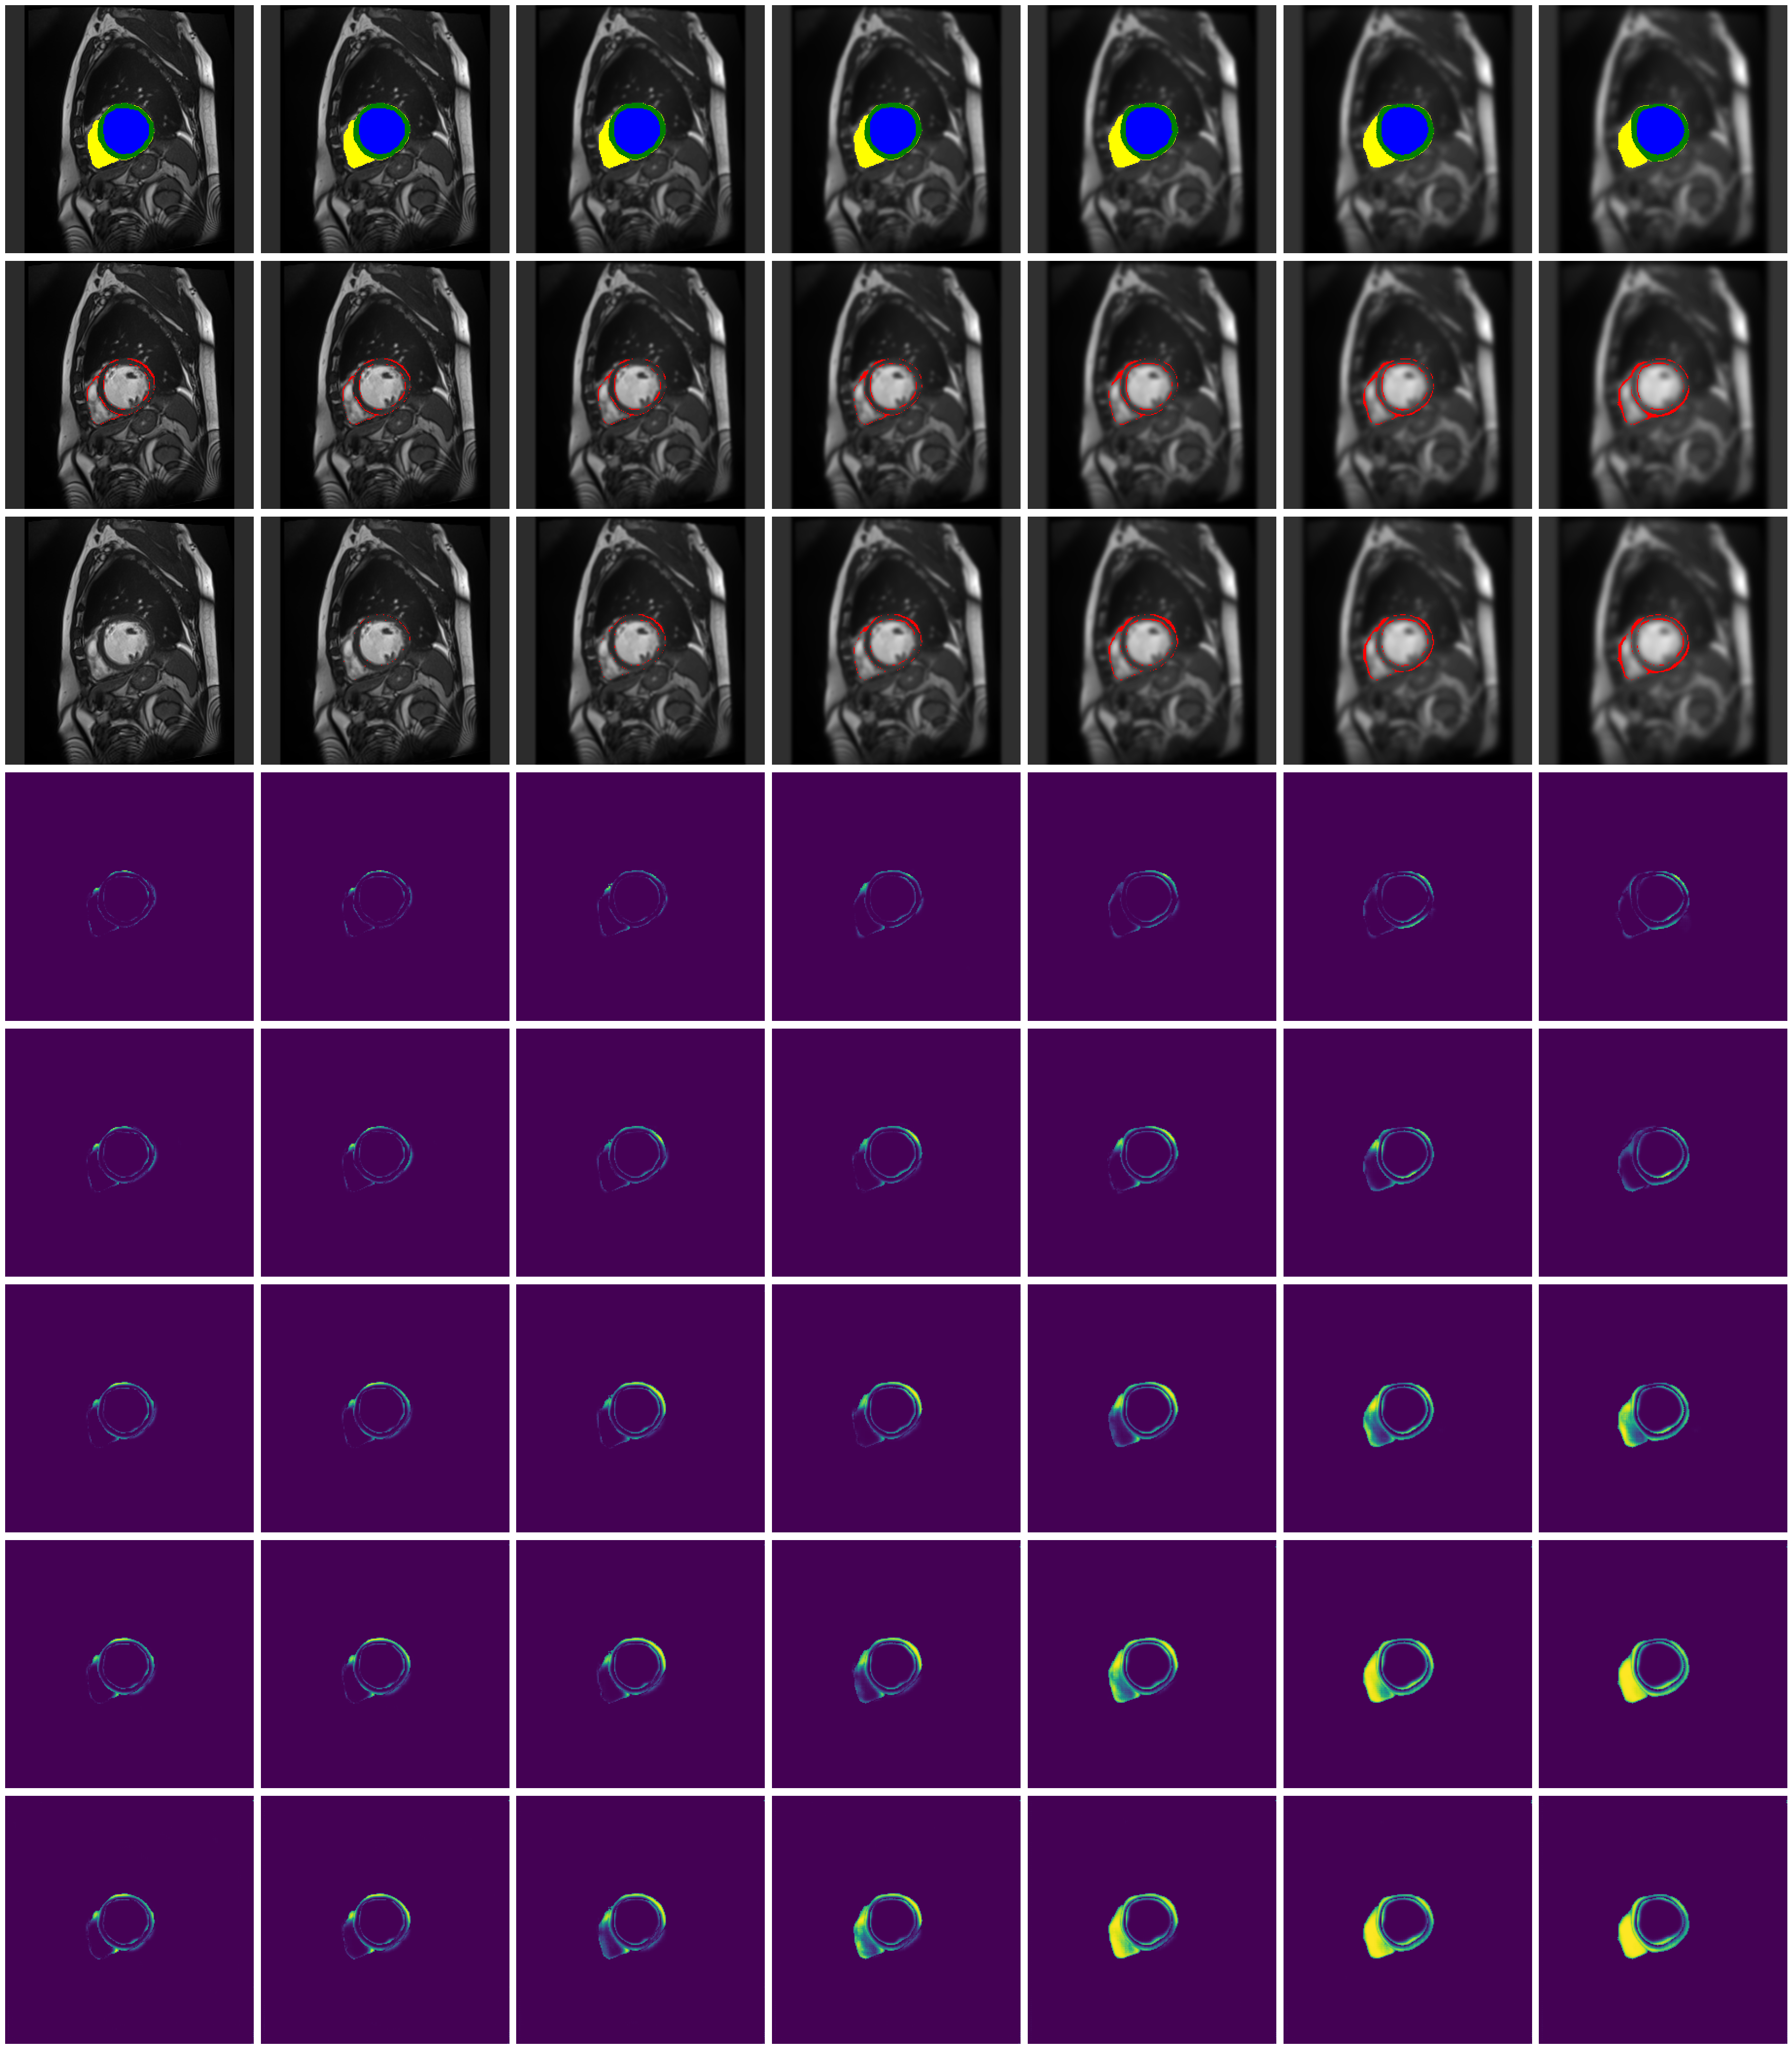

In [13]:
device = ['cuda:0', 'cpu']
# umap = 'top2diff_diff'
umap = 'diff_grad'
# umap='cross_entropy'
net_out = 'heart'

# lr=1e-4
lrs = [1e-2,2e-2, 3e-2,4e-2,5e-2]

n_rows = 3 + len(lrs)
n_cols = len(augments) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

idxs = [i for i in range(5)]
# idxs = [25]
# idx = 40
# mahalanobis_detector.set_lr(lr)

data_sample = data['train'][idxs]
x_ins = data_sample['input']
targets = data_sample['target']
targets[targets == -1] = 0


for idx, x_in, target in zip(idxs, x_ins, targets):
    x_in = x_in.unsqueeze(0)
    target = target.unsqueeze(0)
    
    x_in_aug = torch.cat(augmenter(x_in), dim=0).to(device[0])

    # scores = []
    # value_range = torch.linspace(1e-5, 1e-1, 100)
    mahalanobis_detector.set_transform(False)
    output = mahalanobis_detector(x_in_aug).detach().cpu()
    seg_map = torch.argmax(output, dim=1, keepdims=True)
    error_map = (seg_map != target).float()
    flip_map  = (seg_map != seg_map[:1]).float()

    mahalanobis_detector.set_transform(True)
    umap_collection = []
    for lr in lrs:

        mahalanobis_detector.set_lr(lr)
        output_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
        umaps_in = torch.cat([output, output_transformed], dim=0)
        umaps = umap_generator(
            umaps_in,
            batch_size=output.shape[0]
        ) / lr

        umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())

        umap_collection.append(umaps)

    for i in range(n_cols):
        # Images with increasing blur + segmentation overlay
        axes[0, i].imshow(x_in_aug[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].imshow(seg_map[i].squeeze().cpu().numpy(), cmap=seg_cmap, norm=seg_norm)
        # Images with increasing blur + error overlay
        axes[1, i].imshow(x_in_aug[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].imshow(error_map[i].squeeze().cpu().numpy(), cmap=err_cmap, norm=err_norm)
        # Images with increasing blur + label flip overlay w.r.t. original segmentation
        axes[2, i].imshow(x_in_aug[i].squeeze().cpu().numpy(), cmap='gray')
        axes[2, i].imshow(flip_map[i].squeeze().cpu().numpy(), cmap=err_cmap, norm=err_norm)
        # U-Map for increasing blur
        for j in range(3, len(lrs)+3):
            axes[j, i].imshow(
                umap_collection[j-3][i].squeeze().cpu().numpy(), 
                cmap='viridis')
        
    for ax in axes.ravel():
        ax.set_axis_off()
        
    plt.tight_layout()
    fig.savefig(f'figures/umap_{idx}.png')

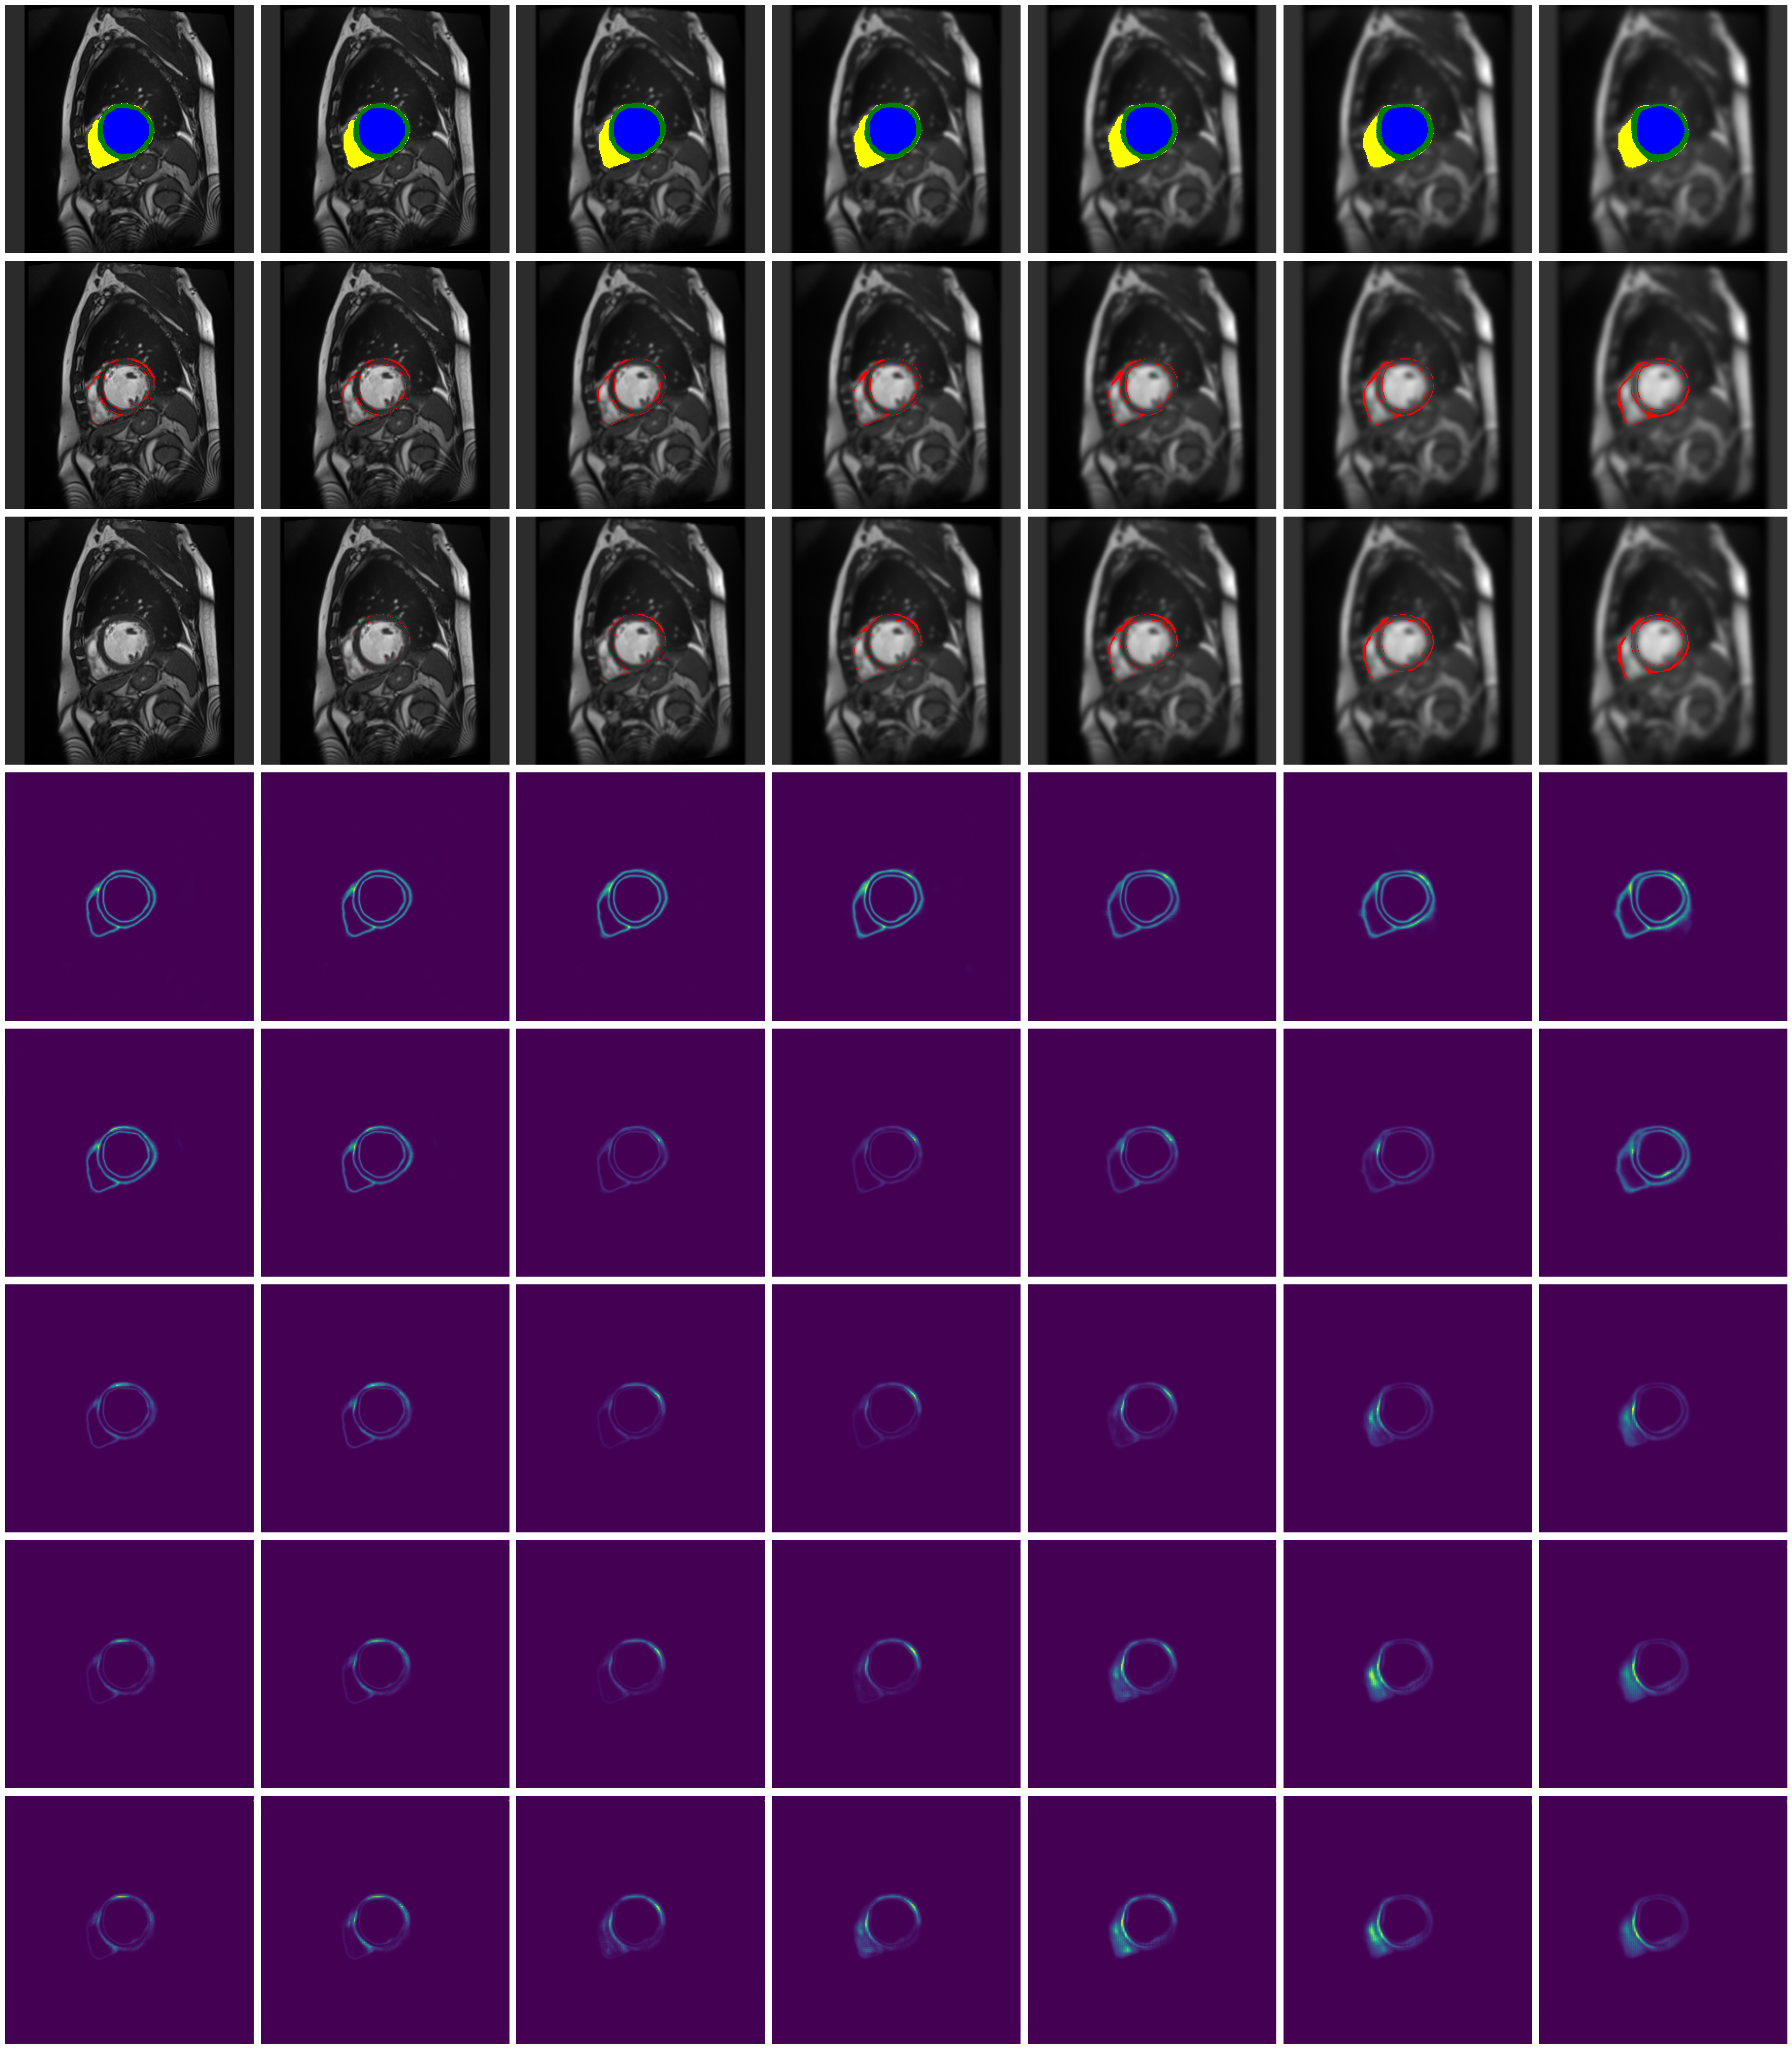

In [14]:
device = ['cuda:0', 'cpu']
# umap = 'top2diff_diff'
# umap = 'diff_grad'
umap='cross_entropy'
net_out = 'heart'

# lr=1e-4
lrs = [1e-2,2e-2, 3e-2,4e-2,5e-2]

n_rows = 3 + len(lrs)
n_cols = len(augments) + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 5))

umap_generator = UMapGenerator(
    method=umap,
    net_out=net_out,
).to(device[0])

idxs = [i for i in range(5)]
# idxs = [25]
# idx = 40
# mahalanobis_detector.set_lr(lr)

data_sample = data['train'][idxs]
x_ins = data_sample['input']
targets = data_sample['target']
targets[targets == -1] = 0


for idx, x_in, target in zip(idxs, x_ins, targets):
    x_in = x_in.unsqueeze(0)
    target = target.unsqueeze(0)
    
    x_in_aug = torch.cat(augmenter(x_in), dim=0).to(device[0])

    # scores = []
    # value_range = torch.linspace(1e-5, 1e-1, 100)
    mahalanobis_detector.set_transform(False)
    output = mahalanobis_detector(x_in_aug).detach().cpu()
    seg_map = torch.argmax(output, dim=1, keepdims=True)
    error_map = (seg_map != target).float()
    flip_map  = (seg_map != seg_map[:1]).float()

    mahalanobis_detector.set_transform(True)
    umap_collection = []
    for lr in lrs:

        mahalanobis_detector.set_lr(lr)
        output_transformed = mahalanobis_detector(x_in_aug).detach().cpu()
        umaps_in = torch.cat([output, output_transformed], dim=0)
        umaps = umap_generator(
            umaps_in,
            batch_size=output.shape[0]
        ) / lr

        umaps = (umaps - umaps.min()) / (umaps.max() - umaps.min())

        umap_collection.append(umaps)

    for i in range(n_cols):
        # Images with increasing blur + segmentation overlay
        axes[0, i].imshow(x_in_aug[i].squeeze().cpu().numpy(), cmap='gray')
        axes[0, i].imshow(seg_map[i].squeeze().cpu().numpy(), cmap=seg_cmap, norm=seg_norm)
        # Images with increasing blur + error overlay
        axes[1, i].imshow(x_in_aug[i].squeeze().cpu().numpy(), cmap='gray')
        axes[1, i].imshow(error_map[i].squeeze().cpu().numpy(), cmap=err_cmap, norm=err_norm)
        # Images with increasing blur + label flip overlay w.r.t. original segmentation
        axes[2, i].imshow(x_in_aug[i].squeeze().cpu().numpy(), cmap='gray')
        axes[2, i].imshow(flip_map[i].squeeze().cpu().numpy(), cmap=err_cmap, norm=err_norm)
        # U-Map for increasing blur
        for j in range(3, len(lrs)+3):
            axes[j, i].imshow(
                umap_collection[j-3][i].squeeze().cpu().numpy(), 
                cmap='viridis')
        
    for ax in axes.ravel():
        ax.set_axis_off()
        
    plt.tight_layout()
    fig.savefig(f'figures/umap_CE_{idx}.png')

In [20]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=5e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='top2diff',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.36562836170196533
1.0: 0.36421477794647217
1.5: 0.37277212738990784
2.0: 0.3868952691555023
2.5: 0.3966067135334015
3.0: 0.40939992666244507


In [ ]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=5e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='diff_grad',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.052302081137895584
1.0: 0.3019622564315796
1.5: 0.35226690769195557
2.0: 0.3830333352088928
2.5: 0.4489980936050415
3.0: 0.5092993974685669


In [42]:


augs = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
)


mahalanobis_detector = get_pooling_mahalanobis_detector(
    swivels=['up3.0.conv_path.0.bn'],
    unet=unet,
    sigma_algorithm='default',
    fit='raw',
    iid_data=dataloader,
    transform=True,
    lr=5e1,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")

0.5: 0.20214003324508667
1.0: 0.31817156076431274
1.5: 0.3500712513923645
2.0: 0.3798588812351227
2.5: 0.39080309867858887
3.0: 0.3968576192855835


In [52]:
augs = get_gaussian_domainshift_augments(
    sigmas = [0.5 * i for i in range(1, 7)]
    # sigmas = [2.5]
)

0.5: 0.18165791034698486
1.0: 0.3563685715198517
1.5: 0.4095529615879059
2.0: 0.45301133394241333
2.5: 0.5147583484649658
3.0: 0.5734955668449402


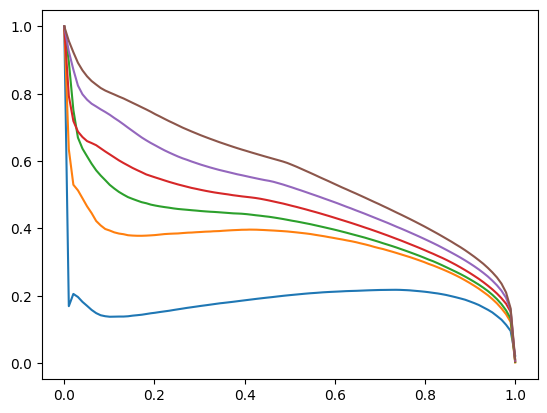

In [55]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=True,
    aggregate='mean',
    transform=True,
    lr=4e4,
    device='cuda:0'
)

# for lr in [3.4e4, 3.5e4, 3.6e4, 3.7e4, 3.8e4, 3.9e4]:
    # mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    #     swivels=swivels,
    #     unet=unet,
    #     reduce=True,
    #     aggregate='mean',
    #     transform=True,
    #     lr=lr,
    #     device='cuda:0'
    # )
for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector,
        dataset=data['train'],
        net_out='heart',
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")
    plt.plot(r, p, label=f'{aug.sigma[1]}')
plt.show()

0.5: 0.193344846367836
1.0: 0.35372355580329895
1.5: 0.4085277318954468
2.0: 0.4560043513774872
2.5: 0.5190661549568176
3.0: 0.5780220627784729


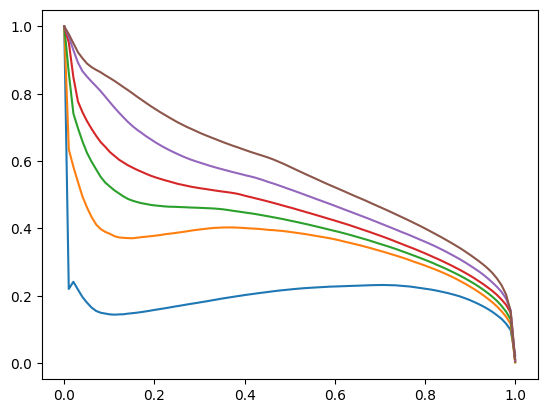

In [31]:
swivels = [layer[0] for layer in unet.named_modules() if 'bn' in layer[0]]

mahalanobis_detector = get_batchnorm_mahalanobis_detector(
    swivels=swivels,
    unet=unet,
    reduce=False,
    aggregate='mean',
    transform=True,
    lr=5e5,
    device='cuda:0'
)

for aug in augs:
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=aug,
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{aug.sigma[1]}: {pr_auc}")
    plt.plot(r, p, label=f'{aug.sigma[1]}')

plt.show()

In [41]:
# for aug in augs:
p, r, pr_auc = get_precision_recall_for_domainshift_flips_model(
    model=unet, 
    dataset=data['train'], 
    net_out='heart', 
    umap='entropy',
    domain_shift_aug=augs[0],
    n_taus='auto',
    dae=False,
    device=['cuda:0', 'cpu']
)
print(f"{aug.sigma[1]}: {pr_auc}")

2.0: 0.40558314323425293


500000.0: 0.4209441840648651
800000.0: 0.42596468329429626
1000000.0: 0.4252321720123291
3000000.0: 0.36881452798843384
5000000.0: 0.2993611991405487


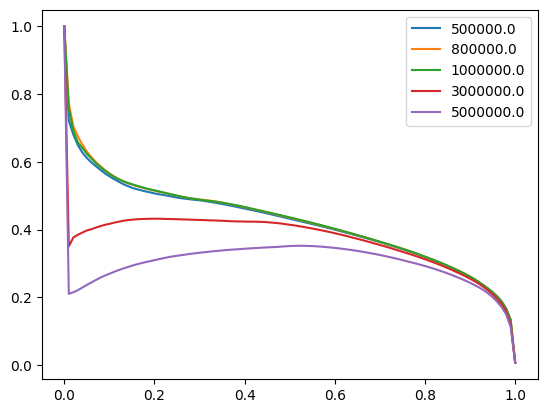

In [28]:
swivels = ['up3.0.conv_path.0.bn']



for lr in [5e5, 8e5, 1e6, 3e6, 5e6]:
    mahalanobis_detector = get_batchnorm_mahalanobis_detector(
        swivels=swivels,
        unet=unet,
        reduce=False,
        aggregate='mean',
        transform=True,
        lr=lr,
        device='cuda:0'
    )
    p, r, pr_auc = get_precision_recall_for_domainshift_flips(
        model=mahalanobis_detector, 
        dataset=data['train'], 
        net_out='heart', 
        umap='cross_entropy',
        domain_shift_aug=augs[4],
        n_taus='auto',
        device=['cuda:0', 'cpu']
    )
    print(f"{lr}: {pr_auc}")
    plt.plot(r, p, label=f'{lr}')

plt.legend()
plt.show()

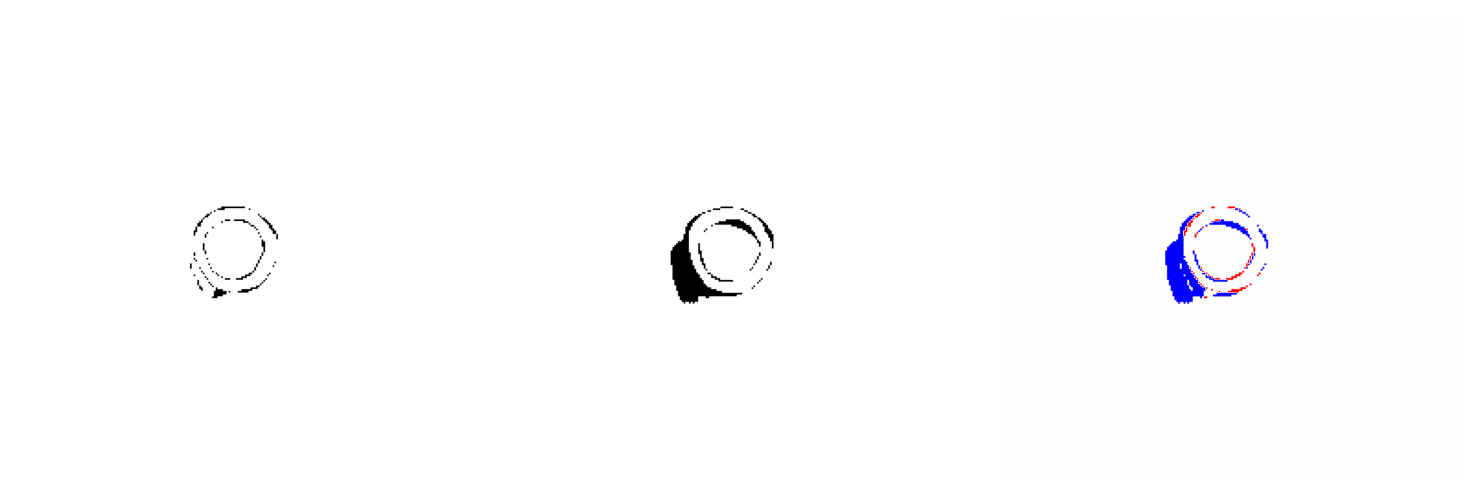

In [124]:
idx = 17


truncate = 4
sigma = 3
radius = round(truncate * sigma)
kernel_size = 2*radius + 1
augmenter = GaussianBlur(
    kernel_size=kernel_size,
    sigma=sigma
)    

ds = data['train'][idx]
img = ds['input']
img_augmented = augmenter(img.unsqueeze(0)).squeeze(0)
target = ds['target'].unsqueeze(0)
target[target == -1] = 0
out = unet(
    torch.stack([img, img_augmented], dim=0).cuda()
).detach().cpu()
segmap = torch.argmax(out, dim=1, keepdims=True)
errmap = (segmap != target).squeeze()

fig, axes = plt.subplots(1, 3, figsize=(15,5))
axes[0].imshow(errmap[0], cmap='Greys')
axes[1].imshow(errmap[1], cmap='Greys')
axes[2].imshow(errmap[0]*1 - errmap[1]*1, cmap='bwr')

for ax in axes.ravel():
    ax.set_axis_off()
plt.tight_layout()